In [1]:
import torch
import torchvision
from torch import nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

from settings import EPOCHS
from unet import UNET
from Discriminator import Discriminator
import torchvision.transforms as transforms
from torch.nn import SoftMarginLoss, BCELoss
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import pytorch_ssim



def trainPix2Pix(model, data, totalEpochs=EPOCHS, genLr=0.0001, descLr=0.00005, useAutoencoderLoss=True):
    genOptimizer = Adam( list(model.gen.parameters()), lr=genLr)
    discOptimizer = Adam( list(model.disc.parameters()), lr=descLr)
    criterion = BCELoss()
    model.gen.train()
    model.disc.train()
    for epoch in range(totalEpochs):
        print(epoch)
        for minibatch, (color_and_gray, gray_three_channel) in enumerate(data):
            gradientStepPix2Pix(model, color_and_gray.cuda(), gray_three_channel.cuda(), criterion, genOptimizer, discOptimizer, useAutoencoderLoss=useAutoencoderLoss)


# assumes minibatch is only colord images.
def gradientStepPix2Pix(model, color, gray, criterion, genOptimizer, discOptimizer, useAutoencoderLoss=True):
    origBW = gray
    origColor = color
    
    
    # train descriminator
    genColor = model.generate(origBW)
    genPairs = torch.cat((origBW, genColor), 3)
    origPairs = torch.cat((origBW, origColor), 3)
    
    # print perf
    print(pytorch_ssim.ssim(genColor[:,:,:,:], origColor[:,:,:,:]))

    descTrainSet = torch.cat((genPairs, origPairs), 0)
    genLabels = (torch.zeros(genPairs.size()[0],1).cuda())
    origLabels =  torch.ones(origPairs.size()[0],1).cuda()
    labels = torch.cat((genLabels,origLabels),0)
    preds =  model.discriminate(descTrainSet)
#     print(("labels: ", labels))
    print(("predictions", preds))
    batch_loss = criterion(preds, labels)
#     print(("batch_loss: ",batch_loss))
    
    model.gen.zero_grad()
    model.disc.zero_grad()
    
    batch_loss.backward()
    discOptimizer.step()

    genColor = model.generate(origBW)
    genPairs = torch.cat((origBW, genColor), 3)
    preds = model.discriminate(genPairs)
    batch_loss = criterion(preds,  torch.ones(genLabels.size()[0], 1).cuda())
    print(("batchLoss",batch_loss))
    
    if useAutoencoderLoss:
        diff = genColor - origColor
        diff = diff * diff
        diff = torch.sum(diff)
        batch_loss += diff
    
    model.gen.zero_grad()
    model.disc.zero_grad()
    batch_loss.backward()
    genOptimizer.step()


class pix2pix(nn.Module):

    def __init__(self):
        super(pix2pix, self).__init__()
        numclasses = 3 #RGB
        numchannels = 64
        self.gen = UNET(numclasses, numchannels)
        self.disc = Discriminator()
#         self.criterion = CrossEntropyLoss()
        self.writer = SummaryWriter('runs/pix2pix')

    def log_image(self, images):
        # write to tensorboard
        img_grid = torchvision.utils.make_grid(images)
        self.writer.add_image('four_fashion_mnist_images', img_grid)

    def log_metrics(self, epoch, loss):
        self.writer.add_scalar('training loss', loss, epoch)
        self.trainData.append(loss)

    def generate(self, greyscale):
        return self.gen(greyscale)
        #Need to add dropout

    def discriminate(self, img):
        #(images, features, height, width)
        # Return average - 1 value for all images
        ret = self.disc(img)
        ret = torch.mean(ret, axis=2)
        ret = torch.mean(ret, axis=2) 
        return ret


In [2]:
def TenToPic(image):
    s = image.size()
    ret = torch.zeros(s[1], s[2], s[0])
    for i in range(s[0]):
        ret[:, :, i] = image[i, :,:]
    return ret.detach().numpy().astype(int)

In [3]:
from utils import get_datasets
train_dataset, test_dataset = get_datasets()
ex = None
for i in train_dataset:
    ex = i

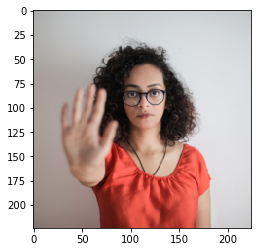

In [4]:
model = pix2pix().cuda()
# out = model.generate(ex[1])
# plt.imshow(TenToPic(out[0,:,:,:]))
# plt.figure()
# plt.imshow(out.detach().numpy()[0,0,:,:])
plt.figure()
plt.imshow(TenToPic(ex[0][0,:,:,:]))
model.cuda()
asdfasdf=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


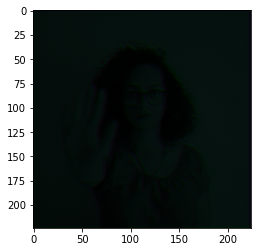

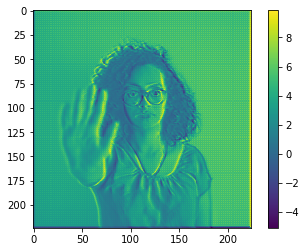

In [5]:
cpuModel = model.cpu()
out = model.generate(ex[1])
plt.imshow(TenToPic(out[0,:,:,:]))
plt.figure()
plt.imshow(out.detach().numpy()[0,0,:,:])
plt.colorbar()
model.cuda()
asdfasdf=1

In [6]:
trainPix2Pix(model, train_dataset, totalEpochs=100, genLr=0.001, descLr=0.01, useAutoencoderLoss=True)

0
tensor(0.0180, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4641],
        [0.4865]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.1832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.1657, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.9741],
        [0.9851]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.1074, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.7280],
        [0.4476]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.3671, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3589],
        [0.5877]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.8447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.3389, device='cuda:0', grad_fn=<MeanB

('batchLoss', tensor(0.6886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8328, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5568],
        [0.4539]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7708, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4578],
        [0.4416]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8389, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4531],
        [0.4193]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.8316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7403, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4652],
        [0.4374]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7888, device='cuda:0', gr

tensor(0.8545, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5140],
        [0.5343]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8922, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4556],
        [0.4390]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4717],
        [0.4659]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7564, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7270, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4517],
        [0.4585]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8403, device='cuda:0', grad_fn=<MeanBac

tensor(0.7789, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4833],
        [0.5871]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8431, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4992],
        [0.5393]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8392, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4563],
        [0.4981]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8515, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4659],
        [0.5675]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6649, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
11
tensor(0.8142, device='cuda:0', grad_fn=<Mean

tensor(0.8575, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4753],
        [0.5499]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8845, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4358],
        [0.4734]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.8172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7793, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4869],
        [0.5189]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8075, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5074],
        [0.4461]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7901, device='cuda:0', grad_fn=<MeanBac

tensor(0.8533, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3906],
        [0.6171]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7541, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4192],
        [0.6107]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
18
tensor(0.8097, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4485],
        [0.5280]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8866, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3869],
        [0.4896]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8534, device='cuda:0', grad_fn=<Mean

tensor(0.8628, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.1319],
        [0.5914]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5629, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8079, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5335],
        [0.4059]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8312, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4798],
        [0.5764]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8058, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3999],
        [0.5477]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.9307, device='cuda:0', grad_fn=<MeanBac

tensor(0.8803, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5520],
        [0.5767]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5725, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8027, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5268],
        [0.4276]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
25
tensor(0.8497, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5423],
        [0.4933]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6722, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8161, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5442],
        [0.5713]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8756, device='cuda:0', grad_fn=<Mean

tensor(0.8441, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4977],
        [0.4887]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7496, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5139],
        [0.5164]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8328, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3881],
        [0.4765]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.8517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7031, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4532],
        [0.4886]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8625, device='cuda:0', grad_fn=<MeanBac

32
tensor(0.8289, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4172],
        [0.6639]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.6559, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5294],
        [0.5282]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8953, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4157],
        [0.6826]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.8127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7216, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3967],
        [0.5696]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8296, device='cuda:0', grad_fn=<Mean

tensor(0.7765, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3119],
        [0.6282]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8540, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4371],
        [0.6756]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8214, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4715],
        [0.7074]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8883, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4315],
        [0.7532]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.4923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
36
tensor(0.8890, device='cuda:0', grad_fn=<Mean

tensor(0.7360, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5542],
        [0.7697]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5613, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7648, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5651],
        [0.7204]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.3977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7593, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4056],
        [0.6387]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5523, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7125, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5672],
        [0.5717]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.6506, device='cuda:0', grad_fn=<MeanBac

tensor(0.7932, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3815],
        [0.6757]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.4905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8137, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.0216],
        [0.5144]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8676, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4029],
        [0.5481]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.8416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
43
tensor(0.8012, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.2358],
        [0.6213]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(1.1338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8802, device='cuda:0', grad_fn=<Mean

tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3979],
        [0.8505]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8375, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4396],
        [0.6316]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7413, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4278],
        [0.7773]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7728, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3468],
        [0.7262]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6736, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8082, device='cuda:0', grad_fn=<MeanBac

tensor(0.7916, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.2972],
        [0.7208]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.9080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8825, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4162],
        [0.8146]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
50
tensor(0.8146, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3864],
        [0.7257]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7648, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3758],
        [0.7607]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7875, device='cuda:0', grad_fn=<Mean

tensor(0.7949, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4317],
        [0.8511]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7720, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3258],
        [0.6768]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8101, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3210],
        [0.5833]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8284, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3319],
        [0.6021]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.4836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8867, device='cuda:0', grad_fn=<MeanBac

tensor(0.7947, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3292],
        [0.7392]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8880, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4163],
        [0.7675]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
57
tensor(0.7827, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3167],
        [0.7273]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8575, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3675],
        [0.8413]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8182, device='cuda:0', grad_fn=<Mean

tensor(0.8561, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4413],
        [0.5990]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7544, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5413],
        [0.6302]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7897, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3231],
        [0.8039]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.8482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8448, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3967],
        [0.7166]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8160, device='cuda:0', grad_fn=<MeanBac

tensor(0.8384, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4529],
        [0.8803]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
64
tensor(0.7703, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3487],
        [0.6792]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8506, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4296],
        [0.6021]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8029, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3821],
        [0.7461]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7059, device='cuda:0', grad_fn=<Mean

tensor(0.8703, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4138],
        [0.7070]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7545, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4895],
        [0.5805]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.4713, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8382, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4152],
        [0.6385]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8082, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3370],
        [0.5660]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8529, device='cuda:0', grad_fn=<MeanBac

tensor(0.7484, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4235],
        [0.5532]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7720, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3066],
        [0.5866]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7375, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3799],
        [0.7395]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7736, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3218],
        [0.6448]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8425, device='cuda:0', grad_fn=<MeanBac

tensor(0.7305, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5018],
        [0.7949]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8499, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4761],
        [0.6935]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8097, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.2624],
        [0.7091]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5611, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8688, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4547],
        [0.7695]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7246, device='cuda:0', grad_fn=<MeanBac

tensor(0.8836, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3094],
        [0.6373]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8216, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.0942],
        [0.5300]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8502, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3230],
        [0.6235]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7615, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3286],
        [0.6004]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7905, device='cuda:0', grad_fn=<MeanBac

tensor(0.7186, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3906],
        [0.6293]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.8189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8326, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3582],
        [0.4997]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8570, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3694],
        [0.7524]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8503, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4558],
        [0.7070]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
82
tensor(0.8226, device='cuda:0', grad_fn=<Mean

tensor(0.7924, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3718],
        [0.4320]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8177, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.2110],
        [0.5856]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8792, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4363],
        [0.5806]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8534, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3418],
        [0.7124]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7618, device='cuda:0', grad_fn=<MeanBac

tensor(0.8286, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.6567],
        [0.6059]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8149, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5316],
        [0.6081]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8392, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4038],
        [0.5707]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.8071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
89
tensor(0.8042, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5831],
        [0.6323]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.3945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8924, device='cuda:0', grad_fn=<Mean

tensor(0.8159, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3475],
        [0.4532]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8603, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4208],
        [0.5398]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8859, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3452],
        [0.5083]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.8043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7998, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3582],
        [0.3767]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8315, device='cuda:0', grad_fn=<MeanBac

tensor(0.8425, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.2721],
        [0.6929]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7516, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8458, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5270],
        [0.6373]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.6215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
96
tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.3884],
        [0.7736]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8484, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4372],
        [0.6579]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.7099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8919, device='cuda:0', grad_fn=<Mean

('batchLoss', tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8469, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4238],
        [0.7019]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7565, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5077],
        [0.4965]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.8676, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.4898],
        [0.7303]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))
tensor(0.7320, device='cuda:0', grad_fn=<MeanBackward0>)
('predictions', tensor([[0.5236],
        [0.6369]], device='cuda:0', grad_fn=<MeanBackward1>))
('batchLoss', tensor(0.5063, device='cuda:0', gr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----------
tensor(0.8352, grad_fn=<MeanBackward0>)
tensor(1.)


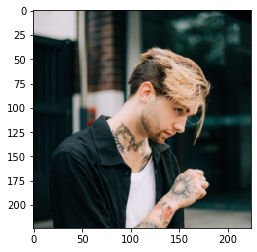

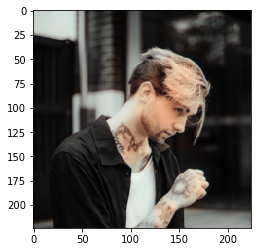

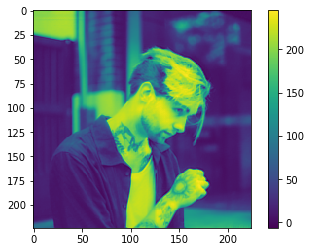

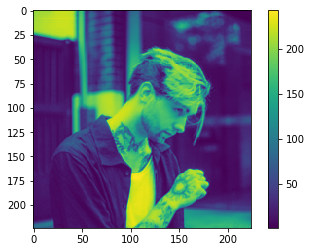

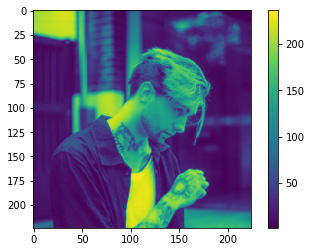

<Figure size 432x288 with 0 Axes>

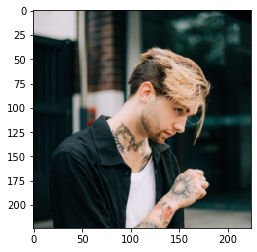

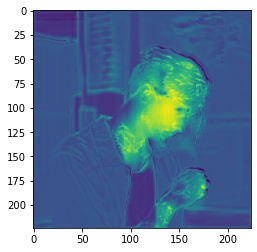

In [18]:
cpuModel = model.cpu()
# out = model.generate(ex[1])
test = None
n = 0
for i in train_dataset:
    test = i
    if n == 7:
        break
    n+=1
out = model.generate(i[1])
plt.figure()
# plt.imshow(TenToPic(ex[1][0,:,:,:]))
plt.imshow(TenToPic(i[0][0,:,:,:]))
plt.figure()
plt.imshow(TenToPic((out[0,:,:,:])))
plt.figure()
plt.imshow(out.detach().numpy()[0,0,:,:])
plt.colorbar()
plt.figure()
plt.imshow(out.detach().numpy()[0,1,:,:])
plt.colorbar()
plt.figure()
plt.imshow(out.detach().numpy()[0,2,:,:])
plt.colorbar()
plt.figure()
model.cuda()
temp = 1
plt.figure()
# plt.imshow(TenToPic(ex[0][0,:,:,:]))
plt.imshow(TenToPic(i[0][0,:,:,:]))
import pytorch_ssim
print("-----------")
# print(pytorch_ssim.ssim(out[:,:,:,:], ex[0][:,:,:,:]))
# print(pytorch_ssim.ssim(ex[0][:,:,:,:], ex[0][:,:,:,:]))
print(pytorch_ssim.ssim(out[:,:,:,:], i[0][:,:,:,:]))
print(pytorch_ssim.ssim(i[0][:,:,:,:], i[0][:,:,:,:]))

diff = out[0,0,:,:] - out[0,1,:,:]
plt.figure()
plt.imshow(diff[:,:].detach().numpy())